In [1]:
import scipy.io as io
import numpy as np
import scipy.sparse.csgraph as cs
import scipy.sparse as sparse
import math
import random
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import time

In [2]:
# graph_name = 'commanche_weighted'
# mat_data = io.loadmat(graph_name + '.mat')
# graph = mat_data['graph']
graph_name = 'dwt_1005'
mat_data = io.loadmat(graph_name + '.mat')
graph = mat_data['Problem']['A'][0][0]
graph_arr = graph.toarray()

# get number of vertices
n = graph.shape[0]
num_of_pivots = 200

# maximum iteration for K_means
max_iter = 50

start_time = time.time()

shortest_paths = cs.shortest_path(graph)

# randomly choose a pivot
p0 = np.random.randint(0, n)
pivots = [p0]

# initialize list of minimum distances to each pivots
mins = []
for i in range(n):
    mins.append([shortest_paths[p0][i], p0])

for i in range(1, num_of_pivots):
    # normal max/min sp:
    argmax = 0
    for k in range(1, n):
        if mins[k][0] > mins[argmax][0]:
            argmax = k
    pivots.append(argmax)

    for j in range(n):
        temp = shortest_paths[pivots[i]][j]
        if temp < mins[j][0]:
            mins[j][0] = temp
            mins[j][1] = pivots[i]

In [3]:
pivots_shortest_paths = []
for p in pivots:
    pivots_shortest_paths.append(shortest_paths[p])

In [4]:
from sklearn.cluster import KMeans
max_iter = 50

kmeans = KMeans(n_init=1, init=np.asarray(pivots_shortest_paths),n_clusters=num_of_pivots, max_iter=max_iter).fit(shortest_paths)
centroids = kmeans.cluster_centers_

In [5]:
from scipy.spatial import distance

pivots = []

for c in centroids:
    euc_dist = distance.cdist([c], shortest_paths, 'euclidean')
    pivots.append(euc_dist.argmin())

In [6]:
# # initialize list of minimum distances to each pivots
# p0 = pivots[0]
# mins = []
# for i in range(n):
#     mins.append([shortest_paths[p0][i], p0])

In [7]:
# regions = {}
# for p in pivots:
#     regions[p] = []

# for i in range(n):
#     for j in range(num_of_pivots):
#         temp = shortest_paths[pivots[j]][i]
#         if temp < mins[i][0]:
#             mins[i][0] = temp
#             mins[i][1] = pivots[j]
#     regions[mins[i][1]].append(i)

In [8]:
def stress_partitioning(n, pivots, dists, region_assignment, region_size, tA, tC, oDist, cur_dist, graph_arr, weights, s, shortest_paths):
    for i in range(len(tA)):
        index = tA[i]
        pivot_no = math.floor(index / n)
        pivot_index = pivots[pivot_no]
        v = index - pivot_no * n
        if region_assignment[v] < 0:
            region_assignment[v] = pivot_index
            region_size[pivot_index] += 1
        #                 pD[pivot_index].append(oDist)
        # pivot_index in this case represent the neighbour pivot of current vertex v
        # check if vertex assigned pivot is its neighbour pivot, if not, reassign the vertex to its neighbour
        if region_size[region_assignment[v]] > (region_size[pivot_index] + 1):
            region_size[region_assignment[v]] -= 1
            region_assignment[v] = pivot_index
            region_size[pivot_index] += 1
    for i in range(len(tC)):
        index = tC[i]
        pivot_no = math.floor(index / n)
        pivot_index = pivots[pivot_no]
        v = index - pivot_no * n
        if (oDist > 0) and (region_assignment[v] != pivot_index) and (v not in graph_arr[pivot_index].nonzero()[0]):
            weights[(v, pivot_index)] = s[pivot_index] / shortest_paths[pivot_index][v] ** 2
            if (pivot_index, v) not in weights:
                weights[(pivot_index, v)] = 0
            dists[(pivot_index, v)] = dists[(v, pivot_index)] = shortest_paths[pivot_index][v]
    for key in region_size:
        for i in range(len(region_assignment)):
            if s[key] == region_size[key]:
                break
            if region_assignment[i] == key and shortest_paths[key][i] <= cur_dist / 2 and key != i:
                s[key] += 1

#### Implement Multi-Source Shortest Paths

In [9]:
from heapdict import heapdict
import math

start_time = time.time()
weights = {}
dists = {}
I, J, V = sparse.find(graph)
for e in range(len(I)):
    i, j, v = I[e], J[e], V[e]
    if i < j:
        weights[(i, j)] = weights[(j, i)] = 1/v**2
        dists[(i, j)] = dists[(j, i)] = v

# initialize priority queue
q = heapdict()
# initialize pivot distance to every other vertices
# pD = []
# for p in pivots:
#     pD.append(shortest_paths[p])


# initialize marking for nodes
mark = [False] * num_of_pivots * n

# initialize cluster assignment for each vertex
region_assignment = [-1] * n
region_size = {}

# initialize s for each pivot
s = {}

for i in range(num_of_pivots):
    q[i * n + pivots[i]] = 0.0
    s[pivots[i]] = 0
    region_size[pivots[i]] = 0

# initialize distances
cur_dist = 0
oDist = 0
tA = []
tC = []

while len(q) != 0:
    cur_index, cur_dist = q.popitem()
    if oDist != cur_dist:
        stress_partitioning(n, pivots, dists, region_assignment, region_size, tA, tC, oDist, cur_dist, graph_arr, weights, s,
                            shortest_paths)
        oDist = cur_dist
        tA.clear()
        tC.clear()
        # continue

    pivot_num = math.floor(cur_index / n)
    v = cur_index - pivot_num * n
    mark[cur_index] = True
    tC.append(cur_index)
    # Assign to cluster if not yet assigned
    if region_assignment[v] < 0:
        tA.append(cur_index)
    neighbours = graph_arr[v].nonzero()[0]
    for w in neighbours:
        neighbour_index = cur_index - v + w
        if not mark[neighbour_index]:
            q[neighbour_index] = cur_dist + shortest_paths[w][v]

stress_partitioning(n, pivots, dists, region_assignment, region_size, tA, tC, oDist, cur_dist, graph_arr, weights, s, shortest_paths)
end_time = time.time()

183049
3.0 0.0017301038062283738 -0.6971979464524667
....................Computation time: 32.44


C:\Users\Win10\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


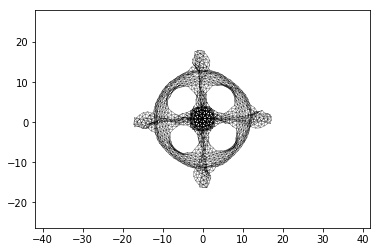

In [10]:
# adjust the weights
# start_time = time.time()
# weights = {}
# dists = {}

# for p in pivots:
#     for i in range(n):
#         if graph[p, i] == 0 and p != i:
#             # ignore neighbours;
#             s = sum(1 for j in regions[p] if shortest_paths[p][j] <= shortest_paths[p][i] / 2)
#             w = 1/shortest_paths[p][i] ** 2

#             weights[(i, p)] = s * w
#             if (p, i) not in weights:
#                 weights[(p, i)] = 0

#             dists[(p, i)] = dists[(i, p)] = shortest_paths[p][i]

#     print('.', end='')

# I, J, V = sparse.find(graph)
# for e in range(len(I)):
#     i, j, v = I[e], J[e], V[e]
#     if i < j:
#         weights[(i, j)] = weights[(j, i)] = 1/v**2
#         dists[(i, j)] = dists[(j, i)] = v
# end_time = time.time()

constraints = []
for ij in dists.keys():
    i = ij[0]
    j = ij[1]
    if i < j:
        constraints.append((i, j, dists[ij]))

print(len(constraints))
        
w_max = 0
w_min = math.inf

for w in weights.values():
    if w != 0:
        w_max = max(w, w_max)
        w_min = min(w, w_min)
        
c_max = 1 / w_min
c_min = 0.1 / w_max

num_iter = 15

lambd = np.log(c_min/c_max) / (num_iter-1)
print("{} {} {}".format(w_max, w_min, lambd))

cool = lambda k: c_max * np.exp(lambd*k)

X = np.random.rand(n, 2)
for k in range(num_iter + 5):
    random.shuffle(constraints)
    c = cool(k - 1)

    for i, j, d in constraints:
        w_i = min(weights[(i, j)] * c, 1)
        w_j = min(weights[(j, i)] * c, 1)
        ij = X[i] - X[j]
        mag = np.linalg.norm(ij)
        m = ((d - mag) / 2) * (ij / mag)

        X[i] += w_i * m
        X[j] -= w_j * m

    print('.', end='')

# end_time = time.time()

print("Computation time: %.2f" % (end_time - start_time))
    
plt.axis('equal')
ax = plt.axes()
ax.set_xlim(min(X[:, 0])-10, max(X[:, 0])+10)
ax.set_ylim(min(X[:, 1])-10, max(X[:, 1])+10)

lines = []
for i, j in zip(*graph.nonzero()):
    lines.append([X[i], X[j]])

lc = mc.LineCollection(lines, linewidths=.3, colors='#0000007f')
ax.add_collection(lc)

plt.savefig(graph_name + '.svg', dpi=1000)
plt.show()


In [11]:
stress = 0
for i in range(n):
    for j in range(i):
        pq = X[i] - X[j]
        mag = np.linalg.norm(pq)
        
        stress += (1/shortest_paths[i,j]**2) * (shortest_paths[i,j]-mag)**2
        
print('stress = {:.0f}'.format(stress))

stress = 10918
